In [11]:
import itertools
import random
import matplotlib.pyplot as plt

%matplotlib inline
import networkx as nx

#  Network models

Contents:
1. [Random network model](#1.-Random-Network-Model)
2. [Small-World model](#2.-Small-World-Model)
3. [Preferential attachment model](#3.-Preferential-Attachment-Model)


## 1. Random Network Model

The random network model has two parameters: the number of nodes $N$, and the link probability $p$. The algorithm for creating this network is as follows:

1. Select a pair of nodes, say i and j.
2. Generate a random number r between 0 and 1. If r < p, then add a link between i and j.
3. Repeat (1) and (2) for all pairs of nodes.


### Gilbert random graph model

In [12]:
def gnp_random_graph(N, p):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    for i, j in itertools.combinations(G.nodes(), 2):
        r = random.random()
        if r < p:
            G.add_edge(i, j)
        # Do nothing if r >= p
        
    return G

We can use this function to generate a graph. Since this is a random graph, each execution of the following code will generate a different graph. 

Graph has 470 edges.


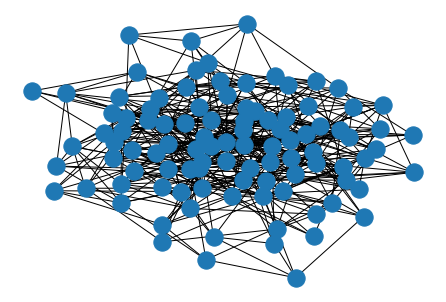

In [15]:
G = gnp_random_graph(100, 0.1)
nx.draw(G)
print('Graph has', G.number_of_edges(), 'edges.')

Run the above cell a few times and note that the number of edges varies slightly among random graphs generated with the same parameters. This is because each pair of nodes has an independent chance of being an edge.

### Erdös-Rényi random graph model

Instead of specifying the link probability $p$, we can also generate a graph of $N$ nodes with exactly $M$ edges by using `random.sample()` to choose M of the possible edges generated with `itertools.combinations()`:

In [8]:
def gnm_random_graph(N, M):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    possible_edges = itertools.combinations(G.nodes(), 2)
    edges_to_add = random.sample(list(possible_edges), M)
    G.add_edges_from(edges_to_add)
    
    return G

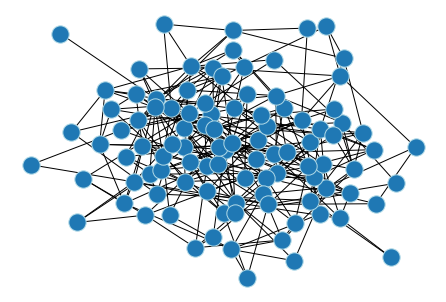

In [16]:
G = gnm_random_graph(100, 300)
pos = nx.spring_layout(G)
nx.draw(G,edgecolors='lightblue')
plt.savefig('graph_er.jpg')

### NetworkX functions

NetworkX has a function for the $G_{n,p}$ random graph specifying number of nodes $N$ and link probability $p$:  [gnp_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnp_random_graph.html).

In addition, NetworkX provides [gnm_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnm_random_graph.html), which generates a $G_{n,m}$ graph, where we specify the number of nodes $N$ and the desired number of edges $M$.

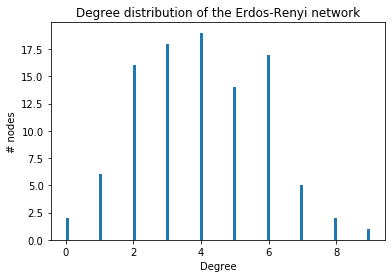

In [7]:
degrees = dict(G.degree()).values() # degree returns a view object DegreeView  
degree_hist = plt.hist(list(degrees), 100)
plt.xlabel('Degree')
plt.ylabel('# nodes')
plt.title('Degree distribution of the Erdos-Renyi network')
#plt.show()
plt.savefig('histo_er.jpg')
plt.show()

## 3. Small-World Model

The algorithm for generating a small-world network is as such:

1. Begin with a ring of $N$ nodes
2. Connect each node to its $k$ nearest neighbors (or $k-1$ if k is odd).
3. For each edge $(u, v)$, with probability $p$, replace edge $(u, v)$ with $(u, w)$ where $w$ is not a neighbor of $u$.

We'll do these step-by-step first, and combine them into a function last.

### Create a ring of N nodes

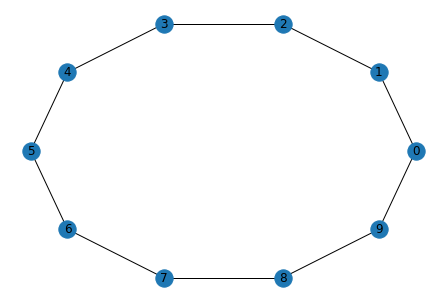

In [18]:
N = 10
G = nx.cycle_graph(N)
nx.draw_circular(G, with_labels=True)

### Connect each node to its $k$ nearest neighbors

We'll use modular arithmetic in order to do this. As an example of why, let's say $k$ is 4. So for node $n$, we want to add edges to $n$'s 4 nearest neighbors: $n-1, n+1, n-2,$ and $n+2.$ Since our nodes are in a circle, these can "wrap around", *e.g.* the 4 nearest neighbors of node 0 are N-1, 1, N-2, and 2.

Note the use of integer division (//) below. Integer division throws away the fractional part of division, e.g.

    5 // 2 = 2

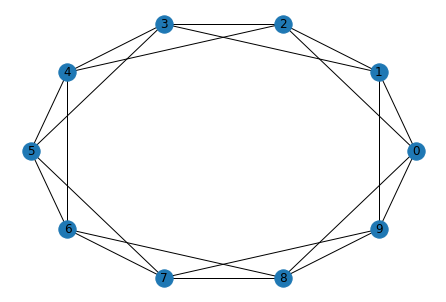

In [19]:
k = 4

for n in G.nodes():
    for i in range(1, k // 2 + 1):
        left  = (n-i) % N
        right = (n+i) % N 
        G.add_edge(n, left)
        G.add_edge(n, right)

nx.draw_circular(G, with_labels=True)

### Rewire some edges

> For each edge $(u, v)$, with probability $p$, replace edge $(u, v)$ with (u, w) where $w$ is not a neighbor of $u$.

For this step, we make use of set arithmetic in order to generate a list of nodes that are not neighbors of $u$, and `random.choice` to select $w$ at random from that set of "not neighbors."

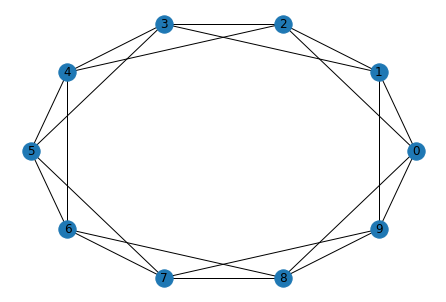

In [20]:
p = 0.01

for u, v in list(G.edges()):
    if random.random() < p:
        not_neighbors = set(G.nodes()) - set(G.neighbors(u))
        w = random.choice(list(not_neighbors))
        G.remove_edge(u, v)
        G.add_edge(u, w)

nx.draw_circular(G, with_labels=True)

### Watts-Strogatz Small-World Model

We can put this together to write a basic function for the small-world model:

In [23]:
def watts_strogatz_graph(N, k, p):
    # 1. Create a ring of N nodes
    G = nx.cycle_graph(N)

    # 2. Connect each node n to k nearest neighbors
    #    [n-(k//2), ... , n-1, n+1, ... , n+(k//2)]
    for n in G.nodes():
        for i in range(1, k // 2 + 1):
            left  = (n-i) % N
            right = (n+i) % N 
            G.add_edge(n, left)
            G.add_edge(n, right)
    
    # 3. Rewire edges with probability p
    for u, v in list(G.edges()):
        if random.random() < p:
            not_neighbors = set(G.nodes()) - set(G.neighbors(u)) - {u}
            w = random.choice(list(not_neighbors))
            G.remove_edge(u, v)
            G.add_edge(u, w)

    return G

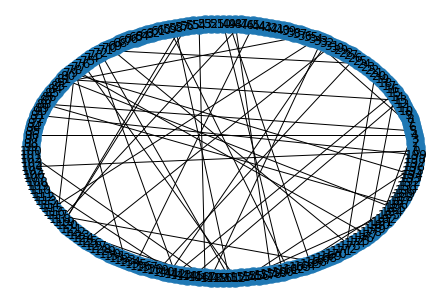

In [27]:
G = watts_strogatz_graph(200, 4, 0.1)
nx.draw_circular(G, with_labels=True)

In [28]:
# Average distance
nx.average_shortest_path_length(G)

5.65140703517588

### NetworkX function

NetworkX has a function for this model: [watts_strogatz_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html).

## 4. Preferential Attachment Model

The Barabási-Albert preferential attachment model has two parameters: the number of nodes $N$, and the number of links added at each step $m$. Given these parameters, the algorithm is as follows:

1. Start with a clique of $m + 1$ nodes.
2. Select $m$ different nodes at random, weighted by their degree.
3. Add a new node $i$ and link it with the $m$ nodes from the previous step.
4. Repeat 2-3 until there are N nodes in the graph.

The code for this is thus straightforward, with one possible exception: for step 3, we need to generate a *degree sequence* to weight the random selection. If we have a graph `G`, we can generate such a degree sequence with a list comprehension as follows:

[4, 1, 1, 1, 1]


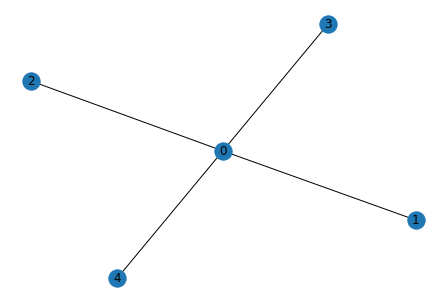

In [13]:
G = nx.star_graph(4)
degrees = [G.degree(n) for n in G.nodes()]

print(degrees)
nx.draw(G, with_labels=True)

Note that the degree sequence is output in the same order as the nodes, such that the node at index $i$ in that list has the degree at index $i$ of the corresponding degree sequence. With this, we can write a function for the BA preferential attachment model:

In [29]:
def barabasi_albert_graph(N, m):
    # 1. Start with a clique of m+1 nodes
    G = nx.complete_graph(m + 1)
    for i in range(G.number_of_nodes(), N):
        # 2. Select m different nodes at random, weighted by their degree.
        new_neighbors = []
        possible_neighbors = list(G.nodes())
        for _ in range(m):
            degrees = [G.degree(n) for n in possible_neighbors]
            
            j = random.choices(possible_neighbors, degrees)[0]
            new_neighbors.append(j)
            possible_neighbors.remove(j)
        
        # 3. Add a new node i and link it with the m nodes from the previous step.
        for j in new_neighbors:
            G.add_edge(i, j)

    return G

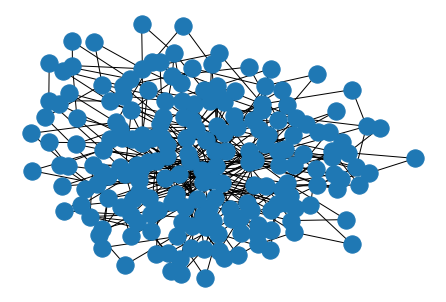

In [32]:
G = barabasi_albert_graph(200, 2)
nx.draw(G)
plt.savefig('graph_ba.jpg')

One might wonder why, in the previous code for `preferential_attachment_graph`, we didn't just write step 2 as

    new_neighbors = random.choices(G.nodes, degrees, k=m)
    
The issue here is that when one specifies $k > 1$ for `random.choices`, the selection is made with replacement, *i.e.* the same node can be selected from the list multiple times. The more complicated code is necessary so that we choose $m$ different nodes to join with node $i$.

### NetworkX function

As with all of these graph models, NetworkX has a function to generate a BA model: [barabasi_albert_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html).

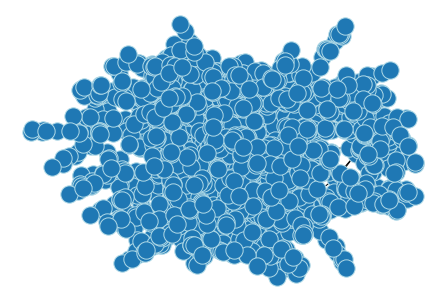

In [18]:
G_BA = nx.barabasi_albert_graph(2000, 1)
nx.draw(G_BA,edgecolors='lightblue')
plt.savefig('graph_er.jpg')

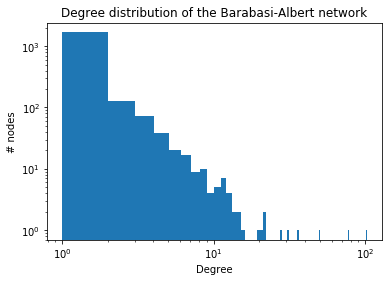

In [19]:
degrees = dict(G_BA.degree()).values() # degree returns a view object DegreeView  
degree_hist = plt.hist(list(degrees), 100)
plt.xlabel('Degree')
plt.ylabel('# nodes')
plt.title('Degree distribution of the Barabasi-Albert network')
#plt.show()
plt.xscale('log')
plt.yscale('log')
plt.savefig('histo_ba.jpg')
plt.show()

In [20]:
from platform import python_version
print(python_version())

3.6.3
